In [1]:
# 0. Load keras package needed
import numpy as np
import tensorflow as tf
import keras
import os # drectory library
import cv2 # image processing library
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import TimeDistributed
from keras import applications
from keras import optimizers
from keras.models import Model
from keras.models import load_model
# Fix random seed
np.random.seed(3)

In [2]:
# Create a dictionary to map encoded labels to their corresponding string labels
label_dict = {
    0: 'America',   # 0 corresponds to 'America'
    1: 'Congress',   # 1 corresponds to 'Congress'
    2: 'Journalist',   # 2 corresponds to 'Journalist'
    3: 'News',   # 3 corresponds to 'News'
    4: 'North Korea',  # 4 corresponds to 'North Korea'
    5: 'President',   # 5 corresponds to 'President'
    6: 'Today',     # 6 corresponds to 'Today'
    7: 'Default',  # 7 corresponds to 'Default'
}


In [3]:
timesteps = 10 # input frame numbers for LSTM
n_labels = 8 # Number of Dataset Labels
Learning_rate = 0.0001 # Oprimizers lr, in this case, for adam
batch_size = 32
validation_ratio = 0.2
num_epochs = 50
img_col = 128 # Transfer model input size ( MobileNet )
img_row = 128 # Transfer model input size ( MobileNet )
img_channel = 3 # RGB

In [4]:
#Clone of the repo containing the dataset and unzip the dataset

!git clone https://github.com/SimArgentino/Lip-reading-CNN
!unzip /content/Lip-reading-CNN/LRW_dataset/Normalized_Cascade.zip
!unzip /content/Lip-reading-CNN/LRW_dataset/Normalized_SVM.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: Normalized SVM/6/36/9.jpg  
   creating: Normalized SVM/6/37/
  inflating: Normalized SVM/6/37/1.jpg  
  inflating: Normalized SVM/6/37/10.jpg  
  inflating: Normalized SVM/6/37/11.jpg  
  inflating: Normalized SVM/6/37/12.jpg  
  inflating: Normalized SVM/6/37/13.jpg  
  inflating: Normalized SVM/6/37/14.jpg  
  inflating: Normalized SVM/6/37/15.jpg  
  inflating: Normalized SVM/6/37/16.jpg  
  inflating: Normalized SVM/6/37/17.jpg  
  inflating: Normalized SVM/6/37/18.jpg  
  inflating: Normalized SVM/6/37/19.jpg  
  inflating: Normalized SVM/6/37/2.jpg  
  inflating: Normalized SVM/6/37/20.jpg  
  inflating: Normalized SVM/6/37/3.jpg  
  inflating: Normalized SVM/6/37/4.jpg  
  inflating: Normalized SVM/6/37/5.jpg  
  inflating: Normalized SVM/6/37/6.jpg  
  inflating: Normalized SVM/6/37/7.jpg  
  inflating: Normalized SVM/6/37/8.jpg  
  inflating: Normalized SVM/6/37/9.jpg  
   creating: Normalized SVM/6/38/
  inflatin

In [5]:
import os

old_name = r"/content/Normalized SVM"
new_name = r"/content/Normalized_SVM"
os.rename(old_name, new_name)

In [6]:
import os

old_name = r"/content/Normalized Cascade"
new_name = r"/content/Normalized_Cascade"
os.rename(old_name, new_name)

In [19]:
# Define temporary empty lists for loading data and labels
data = []
label = []
Totalnb = 0  # Initialize a counter for the total number of datasets

# Load Dataset
for i in range(n_labels):  # Iterate over the number of labels (classes)
    nb = 0  # Initialize a counter for the number of datasets for the current label
    # Counting datasets in each label
    for root, dirs, files in os.walk('/content/Normalized_Cascade/' + str(i+1)):  # Traverse the directory for the current label
        for name in dirs:  # Count the number of subdirectories (each subdirectory represents a dataset)
            nb += 1
    print(i, "Label number of Dataset is:", nb)
    Totalnb += nb  # Add the number of datasets for the current label to the total count

    # For each dataset, read the image data, resize the images, and append to the list
    for j in range(nb):
        temp = []  # Temporary list to hold the images for the current dataset
        for k in range(timesteps):  # Iterate over the timesteps (number of images in each dataset)
            name = '/content/Normalized_Cascade/' + str(i+1) + '/' + str(j+1) + '/' + str(k+1) + '.jpg'  # Construct the file path
            img = cv2.imread(name)  # Read the image
            res = cv2.resize(img, dsize=(img_col, img_row), interpolation=cv2.INTER_CUBIC)  # Resize the image
            temp.append(res)  # Append the resized image to the temporary list
        label.append(i)  # Append the label for the current dataset
        data.append(temp)  # Append the list of images for the current dataset

print("Total Number of Data is", Totalnb)

# Convert lists to numpy arrays for use with Keras
Train_label = np.eye(n_labels)[label]  # One-hot encode the labels
Train_data = np.array(data)  # Convert the list of data to a numpy array
print("Dataset shape is", Train_data.shape, "(size, timestep, column, row, channel)")
print("Label shape is", Train_label.shape, "(size, label onehot vector)")

0 Label number of Dataset is: 82
1 Label number of Dataset is: 74
2 Label number of Dataset is: 86
3 Label number of Dataset is: 66
4 Label number of Dataset is: 70
5 Label number of Dataset is: 81
6 Label number of Dataset is: 69
7 Label number of Dataset is: 58
Total Number of Data is 586
Dataset shape is (586, 10, 128, 128, 3) (size, timestep, column, row, channel)
Label shape is (586, 8) (size, label onehot vector)


In [20]:
# Shuffling the dataset to ensure the model trains properly
# Create an array of indices based on the number of samples in Train_label
x = np.arange(Train_label.shape[0])

# Shuffle the indices array randomly
np.random.shuffle(x)

# Shuffle Train_label and Train_data using the shuffled indices to maintain the same order
Train_label = Train_label[x]
Train_data = Train_data[x]

# Declare data for training (and validation, if needed)
# Here, the entire dataset is used for training, but it can be split further for validation and testing if desired
X_train = Train_data[0:Totalnb, :]  # Select all data for training
Y_train = Train_label[0:Totalnb]    # Select all corresponding labels for training

# Optionally, you can split X_train and Y_train further to create validation and test sets
# For example, to create a validation set, you might do:
test_split = 0.2  # Define the fraction of the dataset to be used for validation
split_index = int(Totalnb * (1 - test_split))  # Calculate the split index
X_test = X_train[split_index:Totalnb, :]
Y_test = Y_train[split_index:Totalnb]
X_train = X_train[0:split_index, :]
Y_train = Y_train[0:split_index]


In [21]:
# 2. Building a Model
# Declare the input layer for the CNN+LSTM architecture
video = Input(shape=(timesteps, img_col, img_row, img_channel))

# Load a pre-trained MobileNet model with specified input shape, pre-trained on ImageNet, excluding the top layers

#HERE YOU CAN CHOOSE THE MODEL:
model = applications.MobileNet(input_shape=(img_col, img_row, img_channel), weights="imagenet", include_top=False)
#model = applications.VGG16(input_shape=(img_col, img_row, img_channel), weights="imagenet", include_top=False)

model.trainable = False  # Freeze the pre-trained model layers to prevent them from being updated during training

# Fully Connected Dense Layer
x = model.output  # Get the output from the pre-trained model
x = Flatten()(x)  # Flatten the output to feed it into fully connected layers
x = Dense(1024, activation="relu")(x)  # Add a dense layer with 1024 units and ReLU activation
x = Dropout(0.3)(x)  # Add dropout for regularization to prevent overfitting
cnn_out = Dense(128, activation="relu")(x)  # Add another dense layer with 128 units and ReLU activation

# Construct the CNN model
Lstm_inp = Model(inputs=model.input, outputs=cnn_out)

# Distribute CNN output by timesteps using TimeDistributed layer
encoded_frames = TimeDistributed(Lstm_inp)(video)

# Construct LSTM model
encoded_sequence = LSTM(256)(encoded_frames)  # Add an LSTM layer with 256 units
hidden_Drop = Dropout(0.3)(encoded_sequence)  # Add dropout for regularization
hidden_layer = Dense(128, activation="relu")(hidden_Drop)  # Add a dense layer with 128 units and ReLU activation
outputs = Dense(n_labels, activation="softmax")(hidden_layer)  # Final output layer with softmax activation for classification

# Construct the complete CNN+LSTM model
model = Model(inputs=[video], outputs=outputs)

# 3. Setting up the Model Learning Process
# Compile the model with Adam optimizer and categorical crossentropy loss function
adam = keras.optimizers.Adam(learning_rate=Learning_rate, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

# 4. Training the Model
# Train the model with the training data
hist = model.fit(X_train, Y_train, batch_size=batch_size, validation_split=validation_ratio, shuffle=True, epochs=num_epochs)


Epoch 1/50
12/12 [==============================] - 7s 239ms/step - loss: 1.8993 - accuracy: 0.2914 - val_loss: 1.7409 - val_accuracy: 0.3191
Epoch 2/50
12/12 [==============================] - 2s 129ms/step - loss: 1.6249 - accuracy: 0.3610 - val_loss: 1.4966 - val_accuracy: 0.3936
Epoch 3/50
12/12 [==============================] - 2s 133ms/step - loss: 1.4510 - accuracy: 0.4545 - val_loss: 1.3898 - val_accuracy: 0.5106
Epoch 4/50
12/12 [==============================] - 2s 136ms/step - loss: 1.3765 - accuracy: 0.4759 - val_loss: 1.3051 - val_accuracy: 0.4681
Epoch 5/50
12/12 [==============================] - 2s 130ms/step - loss: 1.2728 - accuracy: 0.5428 - val_loss: 1.2656 - val_accuracy: 0.5532
Epoch 6/50
12/12 [==============================] - 2s 132ms/step - loss: 1.1830 - accuracy: 0.5615 - val_loss: 1.1665 - val_accuracy: 0.6064
Epoch 7/50
12/12 [==============================] - 2s 130ms/step - loss: 1.0427 - accuracy: 0.6497 - val_loss: 1.1180 - val_accuracy: 0.6170
Epoch 

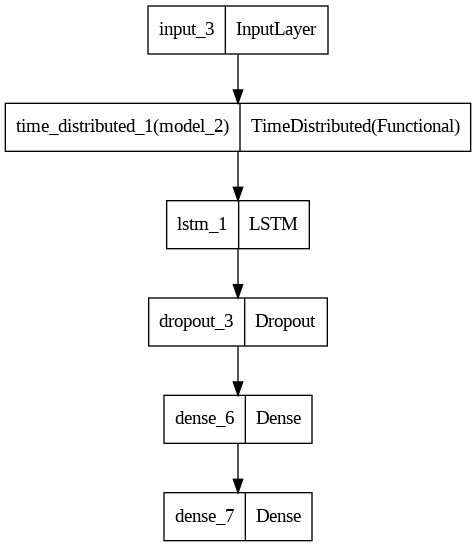

In [22]:
# Model Architecture Visualization
from IPython.display import SVG  # Import SVG display utilities from IPython
from keras.utils import model_to_dot  # Import model_to_dot for converting model architecture to dot format

# Enable inline display of plots in Jupyter notebooks
%matplotlib inline

# Convert the model to dot format and display it as an SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Import plot_model for saving the model architecture as an image file
from keras.utils import plot_model

# Save the model architecture visualization to a file named 'model.png'
plot_model(model, to_file='model.png')


In [23]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 128, 128, 3   0         
                             )]                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 128)           20138304  
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 256)               394240    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 8)                 1032

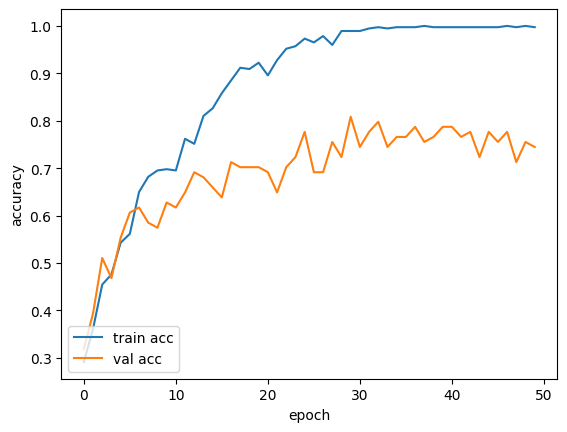

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# Assuming 'hist' is your history object containing loss and accuracy history

# Create a figure and axis objects for loss and accuracy
fig, acc_ax = plt.subplots()

# Plot training and validation accuracy on the secondary y-axis
acc_ax.plot(hist.history['accuracy'], label='train acc')
acc_ax.plot(hist.history['val_accuracy'], label='val acc')

# Set the labels for the x-axis and y-axes
acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')

# Add legends to the plot
acc_ax.legend(loc='lower left')  # Legend for accuracy

# Display the plot
plt.show()

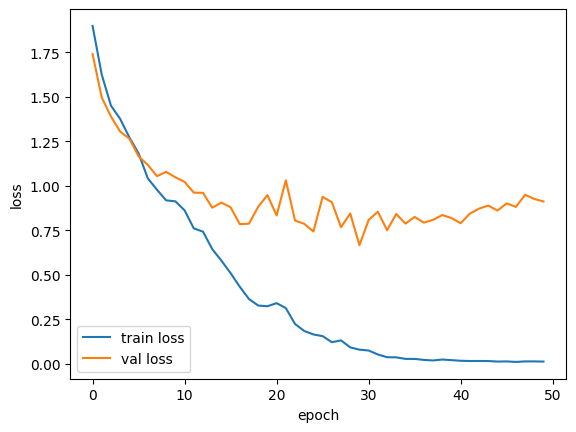

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

# Assuming 'hist' is your history object containing loss and accuracy history

# Create a figure and axis objects for loss and accuracy
fig, loss_ax = plt.subplots()

# Plot training and validation loss on the primary y-axis
loss_ax.plot(hist.history['loss'], label='train loss')
loss_ax.plot(hist.history['val_loss'], label='val loss')

# Set the labels for the x-axis and y-axes
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

# Add legends to the plot
loss_ax.legend(loc='lower left')  # Legend for loss

# Display the plot
plt.show()

In [26]:
# Predict probabilities for each class using the trained model
y_pred_prob = model.predict(X_test)

# Extract the predicted class labels by selecting the index with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)


4/4 [==============================] - 2s 79ms/step


In [27]:
Y_test = np.argmax(Y_test, axis=1)

In [28]:
from sklearn.metrics import classification_report
from prettytable import PrettyTable

# Generate classification report with output in dictionary format
report = classification_report(Y_test, y_pred, output_dict=True)

# Initialize a PrettyTable to display the classification metrics
table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]

# Iterate through each class in the classification report
for label, metrics in report.items():
    # Check if the label is a digit (class label)
    if label.isdigit():
        # Round the metrics to two decimal places for display
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']

        # Map the numeric label to its corresponding class name using label_dict
        class_name = label_dict[int(label)]

        # Add a row to the PrettyTable with class name and metrics
        table.add_row([class_name, precision, recall, f1_score, support])

# Print the PrettyTable
print(table)


+-------------+-----------+--------+----------+---------+
|    Class    | Precision | Recall | F1-Score | Support |
+-------------+-----------+--------+----------+---------+
|   America   |    0.46   |  0.71  |   0.56   |    17   |
|   Congress  |    0.6    |  0.9   |   0.72   |    10   |
|  Journalist |    0.73   |  0.69  |   0.71   |    16   |
|     News    |    0.71   |  0.86  |   0.77   |    14   |
| North Korea |    1.0    |  0.69  |   0.81   |    16   |
|  President  |    0.88   |  0.83  |   0.86   |    18   |
|    Today    |    0.5    |  0.33  |   0.4    |    12   |
|   Default   |    0.44   |  0.27  |   0.33   |    15   |
+-------------+-----------+--------+----------+---------+


4/4 [==============================] - 0s 91ms/step


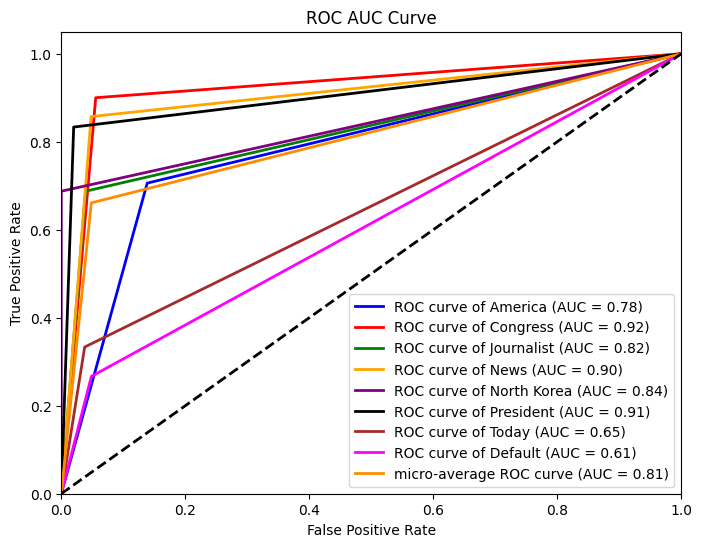

In [29]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert y_true and y_pred to one-hot encoding
n_classes = len(np.unique(Y_test))

# Convert y_true to binary format (one-hot encoding)
y_true_bin = label_binarize(Y_test, classes=np.arange(n_classes))

# Convert y_pred to binary format (one-hot encoding)
y_pred_bin = model.predict(X_test)
y_pred_bin = label_binarize(np.argmax(y_pred_bin, axis=1), classes=np.arange(n_classes))

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curves
plt.figure(figsize=(8,6))
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'black', 'brown', 'magenta', 'gray', 'maroon', 'navy', 'olive', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'
             ''.format(label_dict[i], roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc_micro))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()


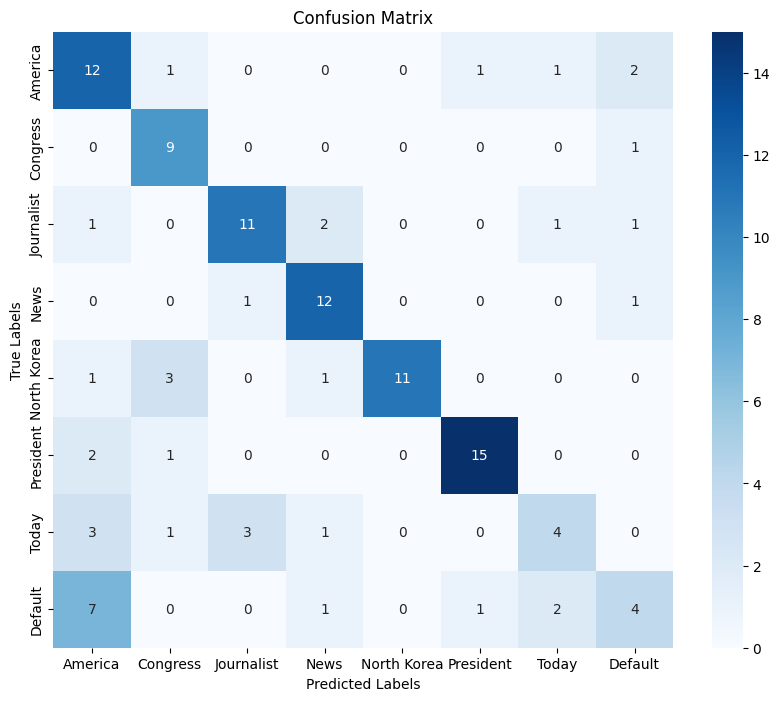

In [30]:
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = sklearn.metrics.confusion_matrix(Y_test, y_pred)

# Define the list of label strings in the order of their integer values
label_strings = [label_dict[i] for i in range(len(label_dict))]

# Generate the heatmap for the confusion matrix
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()
